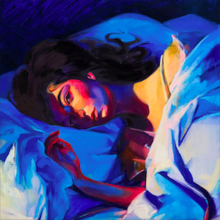

# Lorde - Melodrama Project

This notebook scrapes the album lyrics from Lorde's sophomore album _Melodrama_. 

I am in the process of exploring the data.

In [22]:
import bearer
import requests
from bs4 import BeautifulSoup
import os
import sys
import logging
import pandas as pd

In [2]:
# setup debug logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
base_url = "https://api.genius.com"
headers = {'Authorization': bearer.TOKEN}

In [17]:
def lyrics_from_song_api_path(song_api_path):
  song_url = base_url + song_api_path
  response = requests.get(song_url, headers=headers)
  json = response.json()
  path = json["response"]["song"]["path"]
  #gotta go regular html scraping... come on Genius
  page_url = "http://genius.com" + path
  page = requests.get(page_url)
  html = BeautifulSoup(page.text, "lxml")
  #remove script tags that they put in the middle of the lyrics
  [h.extract() for h in html('script')]
  #at least Genius is nice and has a tag called 'lyrics'!
  lyrics = html.find("div", class_='lyrics').get_text() #updated css where the lyrics are based in HTML
  return lyrics

In [9]:
album_url = 'https://genius.com/albums/Lorde/Melodrama'
artist_name = 'Lorde'

In [10]:
# get the page source for the album
page = requests.get(album_url)
# init a Beautiful Soup obj of the page source
track_soup = BeautifulSoup(page.text, 'lxml')

# find all of the page elements that contain album track information 
tracks = [i.get_text('*', strip=True) for i in track_soup.find_all('h3', class_='chart_row-content-title')]
tracks = tracks[:len(tracks)-1]
# loop through each track and strip out only the track name
for i in range(len(tracks)):
  tracks[i] = tracks[i].split('*')[0]

In [11]:
# this cell obtains the entire corpus of album lyrics
search_url = base_url + "/search"
# dict with track name keys and lyric string values
album_lyrics = {}
# for each track obtain the lyrics and store them into the dict
for song_title in tracks:
  data = {'q': song_title}
  response = requests.get(search_url, data=data, headers=headers)
  json = response.json()
  song_info = None
  for hit in json["response"]["hits"]:
    if hit["result"]["primary_artist"]["name"] == artist_name:
      song_info = hit
      break
  if song_info:
    song_api_path = song_info["result"]["api_path"]
    album_lyrics[song_title] = lyrics_from_song_api_path(song_api_path)

In [19]:
# This is will create a local instance of the PyDictionary class and now it can be used to get meanings, translations etc.
from PyDictionary import PyDictionary
dictionary=PyDictionary()

# the dictionary object returns a dict with the part of speech key and definition as value

In [18]:
# create a working dict of lyrics to be passed into a dataframe object
lyric_dict = {}

In [14]:
# convert the large strings into a list of the lyrics
for i in album_lyrics.keys():
  album_lyrics[i] = album_lyrics[i].split()

In [20]:
# filter by part of speech

# block print out so pyDict don't slow down runtime
sys.stdout = open(os.devnull, 'w')
for track in tracks:
  logger.info('current song: %s' % track)
  for lyric in album_lyrics[track]:
    result = dictionary.meaning(lyric)
    # check if this lyric returned a valid result
    if (type(result) == dict):
      # if the lyric is already present increment its count
      if (lyric in lyric_dict.keys()):
        lyric_dict[lyric][2]+=1
      else:
        # save part of speech and definition to temp vars; then save the lyric to a dict
        # lyric as key, with an array containing part of speech, definition, and count
        pos = result.keys()[0]
        definition = result[pos]
        lyric_dict[lyric] = [pos, definition, 1]

        
  #logger.info(lyric_dict)
        
      
sys.stdout = sys.__stdout__
logger.info('done')

INFO:__main__:current song: Green Light
INFO:__main__:current song: Sober
INFO:__main__:current song: Homemade Dynamite
INFO:__main__:current song: The Louvre
INFO:__main__:current song: Liability
INFO:__main__:current song: Hard Feelings/Loveless
INFO:__main__:current song: Sober II (Melodrama)
INFO:__main__:current song: Writer in the Dark
INFO:__main__:current song: Supercut
INFO:__main__:current song: Liability (Reprise)
INFO:__main__:current song: Perfect Places
INFO:__main__:done


In [36]:
# turn the lyric dictionary into a dataframe
df = pd.DataFrame.from_dict(lyric_dict, orient='index')
df = df.reset_index()
df.columns = ['lyric', 'pos', 'definition', 'count'] # rename columns

In [38]:
df.head()

,lyric,pos,definition,count
0,all,Adjective,"[(quantifier, completely given to or absorbed by]",31
1,liar,Noun,[a person who has lied or who lies repeatedly],1
2,woodwork,Noun,[work made of wood; especially moldings or sta...,3
3,skip,Verb,"[bypass, intentionally fail to attend, jump li...",2
4,go,Adjective,[functioning correctly and ready for action],16


In [42]:
# sort lyrics by frequency
df.sort_values('count', inplace=True)